**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [1]:
%pylab inline
from SimPEG import *
from SimPEG.Utils import io_utils

Populating the interactive namespace from numpy and matplotlib
Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


In [2]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [3]:
# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC, 
# we use VTK to discretize the 3-D space.

mshfile = 'MEsh_TEst.msh'

model_dir = '../../Geological_model/'

# Load mesh file
mesh = Mesh.TensorMesh.readUBC(model_dir+mshfile)

# Create our own mesh!
csx, csy, csz = 25., 25., 25.
ncx, ncy, ncz = 48, 48, 20
npad = 0
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
x0_new = np.r_[mesh.x0[0]+xc, mesh.x0[1]+yc, mesh.x0[2]+zc]
mesh._x0 = x0_new

#Mesh.TensorMesh.writeUBC(mesh,model_dir+"Mesh_mag.msh")
# Define no-data-value
ndv = -100

# Define survey flight height
Z_bird = 20.

# Read in topo surface
topofile = model_dir+'TKCtopo.dat'
geosurf = [
    [model_dir+'Till.ts',True,True,0],
    [model_dir+'XVK.ts',True,True,1],
    [model_dir+'PK1.ts',True,True,2],
    [model_dir+'PK2.ts',True,True,3],
    [model_dir+'PK3.ts',True,True,4],
    [model_dir+'HK1.ts',True,True,5],
    [model_dir+'VK.ts',True,True,6]
]



In [4]:
import time as tm

modelInd = np.ones(mesh.nC)*ndv
for ii in range(len(geosurf)):
    tin = tm.time()
    print "Computing indices with VTK: " + geosurf[ii][0]
    T, S = io_utils.read_GOCAD_ts(geosurf[ii][0])
    indx = io_utils.surface2inds(T,S,mesh, boundaries=geosurf[ii][1], internal=geosurf[ii][2])
    print "VTK operation completed in " + str(tm.time() - tin) + " sec"
    modelInd[indx] = geosurf[ii][3]

Computing indices with VTK: ../../Geological_model/Till.ts
Extracting indices from grid...
VTK operation completed in 8.25099992752 sec
Computing indices with VTK: ../../Geological_model/XVK.ts
Extracting indices from grid...
VTK operation completed in 1.37700009346 sec
Computing indices with VTK: ../../Geological_model/PK1.ts
Extracting indices from grid...
VTK operation completed in 4.43300008774 sec
Computing indices with VTK: ../../Geological_model/PK2.ts
Extracting indices from grid...
VTK operation completed in 1.61599993706 sec
Computing indices with VTK: ../../Geological_model/PK3.ts
Extracting indices from grid...
VTK operation completed in 2.09599995613 sec
Computing indices with VTK: ../../Geological_model/HK1.ts
Extracting indices from grid...
VTK operation completed in 5.28600001335 sec
Computing indices with VTK: ../../Geological_model/VK.ts
Extracting indices from grid...
VTK operation completed in 4.78799986839 sec


In [5]:
import simpegPF as PF
# from simpegPF import BaseMag as MAG
from simpegPF import BaseGrav as Grav
from scipy.interpolate import NearestNDInterpolator

In [6]:
# Load topography file in UBC format and find the active cells
#T, S = io_utils.read_GOCAD_ts(topsurf)
#indx = io_utils.surface2inds(T,S, mesh, boundaries=True, internal=True) 
#actv = np.zeros(mesh.nC)
#actv[indx] = 1

topo = np.genfromtxt(topofile,skip_header=1)
# Find the active cells
actv = PF.Magnetics.getActiveTopo(mesh,topo,'N')


# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)

print "Active cells created from topography!"

Please remove this function! use SimPEG.Utils.surface2ind_topo(mesh, topo, gridLoc='CC')
Active cells created from topography!


In [7]:
# Background density

def getModel(Till=0.0, XVK=-0.5, PK1=-0.5, PK2=-0.5, PK3=-0.5, HK1=-0.5, VK=-0.5, bkgr=0.):
    vals = [Till, XVK, PK1, PK2, PK3, HK1, VK]
    model= np.ones(mesh.nC) * bkgr

    for ii, sus in zip(range(7),vals):
        model[modelInd == ii] = sus
    return model
model = getModel()
dens = getModel()
model = model[actv]

In [8]:
from ipywidgets.widgets import interact, IntSlider

<function __main__.slide>

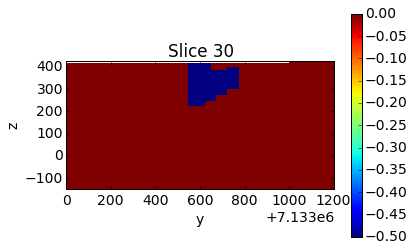

In [9]:
# Here you can visualize the current model
m_true = actvMap*model
#Mesh.TensorMesh.writeModelUBC(mesh,model_dir+"Synthetic_mag.sus",m_true)
airc = m_true==ndv
m_true[airc] = np.nan
def slide(s,normal):
    colorbar(mesh.plotSlice(m_true, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])[0])
    plt.gca().set_aspect('equal')
interact(slide, s=(0,60), normal=['X','Y','Z'])

Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [10]:
# We need to define the direction of the inducing field
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
# The field parameters at TKC are [H:60,308 nT, I:83.8 d D:25.4 d ]
# H0 = (60308.,83.8,25.4)

# We create a synthetic survey with observations in cell center.
X, Y = np.meshgrid(mesh.vectorCCx[::2], mesh.vectorCCy[::2])

# Using our topography, we trape the survey and shift it up by the flight height
Ftopo = NearestNDInterpolator(topo[:,:2], topo[:,2])
Z = Ftopo(Utils.mkvc(X.T),Utils.mkvc(Y.T)) + Z_bird

rxLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = Grav.RxObs(rxLoc)

srcField = Grav.SrcField([rxLoc])
# srcField.param = H0
survey = Grav.LinearSurvey(srcField)


In [11]:
xyz = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]

In [12]:
# Now that we have a model and a survey we can build the linear system ...


# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=len(actv))

# Create the forward model operator
prob = PF.Gravity.GravityIntegral(mesh, mapping=idenMap, actInd=actv)

# Pair the survey and problem
survey.pair(prob)


In [13]:
# Fist time that we ask for predicted data,
# the dense matrix T is calculated.
# This is generally the bottleneck of the integral formulation, 
# in terms of time and memory.
d = prob.fields(model)

Begin calculation of forward operator: z
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



557287.5 7133587.5


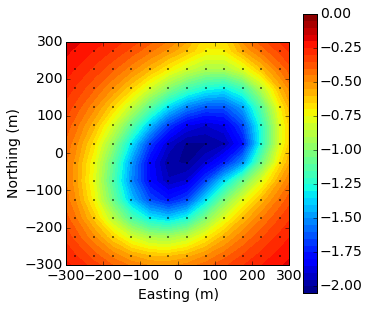

In [17]:
# The main advantage of the integral formulation, is that we can generate data 
# by a simple matrix-vector product. The applet below allows the user to test
# different susceptibility values assigned to the different TKC units

def createData(Till=0.0, XVK=-0.5, PK1=-0.5, PK2=-0.5, PK3=-0.5, HK1=-0.5, VK=-0.5, bkgr=0.):
    model = getModel(Till=Till, XVK=XVK, PK1=PK1, PK2=PK2, PK3=PK3, HK1=HK1, VK=VK, bkgr=bkgr)
    d = prob.fields(model[actv])
    #mesh2d = Mesh.TensorMesh([mesh.hx,mesh.hy],mesh.x0[:2])
    d2D = d.reshape(X.shape)
    plt.figure(figsize=[5,5])
    xc, yc = (X.min()+X.max())*0.5, (Y.min()+Y.max())*0.5
#     colorbar(imshow(d2D,extent=[X.min()-xc, X.max()-xc, Y.min()-yc, Y.max()-yc],origin = 'lower'))
#     plt.contour(X-xc,Y-yc, d2D,20,colors='k')
    dat = plt.contourf(X-xc,Y-yc, d2D,40)    
    plt.colorbar(dat)
    plt.gca().set_aspect('equal')
    plt.plot(X.flatten()-xc,Y.flatten()-yc,'k.', ms=2)
    
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    xlim(-300, 300)
    ylim(-300, 300)    

    print xc, yc
interact(createData, PK1=(-1,0.01,0.001), PK2=(-1,0.01,0.001), PK3=(-1,0.01,0.001), HK1=(-1,0.05,0.001), VK=(-1,0.01,0.001))

In [15]:
# a = hist(abs(survey.dobs), bins=100)

In [16]:
# Add noise to the data and assign uncertainties

# data = d.copy()# We add some random Gaussian noise (1nT)
data = d + randn(len(d))*0.1 # We add some random Gaussian noise (1nT)
wd = np.ones(len(data))*0.08 # Assign flat uncertainties

survey.dobs = data
survey.std = wd

# It is potential fields, so we will need to push the inverison down
# Create distance weights from our linera forward operator
wr = np.sum(prob.G**2.,axis=0)**0.5 / mesh.vol[actv]
wr = ( wr/np.max(wr) )
#wr = PF.Magnetics.get_dist_wgt(mesh, survey.srcField.rxList[0].locs, actv, 3., np.min(mesh.hx)/4.)
#wr = wr**2. # Need to square to be included as weights
    
reg = Regularization.Simple(mesh, indActive = actv, mapping = idenMap)
reg.wght = wr

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1/wd
opt = Optimization.InexactGaussNewton(maxIter=20,maxIterCG= 20, tolCG = 1e-3)

invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Add directives to the inversion
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
beta_init = Directives.BetaEstimate_ByEig(beta0_ratio = 1.)
target = Directives.TargetMisfit()
update_Jacobi = Directives.Update_lin_PreCond(onlyOnStart=True)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,target,beta_init,update_Jacobi])
m0 = np.ones(len(actv))*0.
reg.alpha_s = 0.1
opt.remember('xc')

In [17]:
# Run inversion
ml2 = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  7.38e-02  8.29e+03  0.00e+00  8.29e+03    1.62e+03      0              
   1  3.69e-02  8.59e+02  1.06e+04  1.25e+03    9.03e+01      0              
   2  1.84e-02  6.46e+02  1.46e+04  9.16e+02    5.67e+01      0   Skip BFGS  
   3  9.22e-03  5.32e+02  1.89e+04  7.06e+02    3.52e+01      0   Skip BFGS  
   4  4.61e-03  4.70e+02  2.36e+04  5.79e+02    2.25e+01      0   Skip BFGS  
   5  2.31e-03  4.30e+02  2.98e+04  4.98e+02    1.54e+01      0   Skip BFGS  
   6  1.15e-03  3.96e+02  4.03e+04  4.42e+02    1.17e+01      0   Skip BFGS  
   7  5.76e-04  

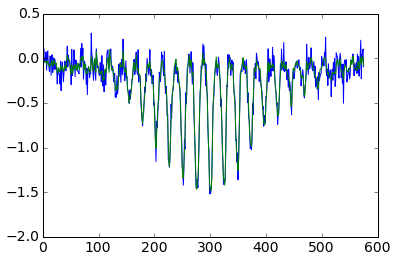

In [18]:
plt.plot(survey.dobs)
plt.plot(invProb.dpred)

In [19]:
# Map model back to full space
xc = opt.recall('xc')
m_l2 = actvMap*xc[4]
m_l2[airc] = np.nan

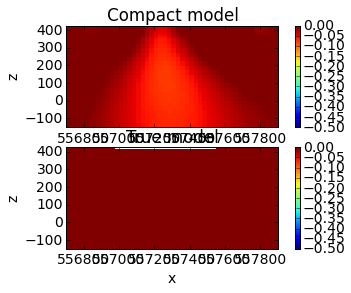

In [20]:
# Inject active cells back into the global mesh and view the recoverd model
vmin, vmax = 0., 0.02
def slide(s,normal):
    ax1 = plt.subplot(2,1,1)
    dat = mesh.plotSlice(m_l2, ax = ax1, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])
    plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('Compact model')
    
    ax2 = plt.subplot(2,1,2)
    dat = mesh.plotSlice(m_true, ax = ax2, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])
    plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('True model')
    
interact(slide, s=(0,60), normal=['X','Y','Z'])

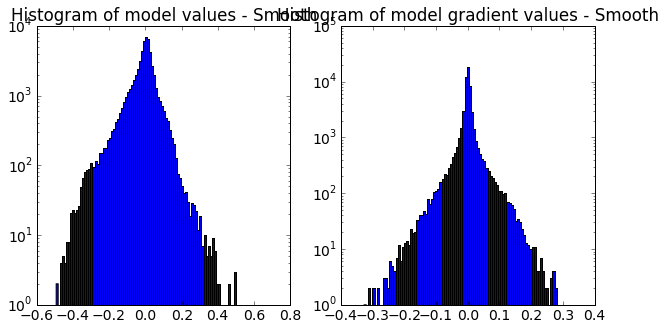

In [21]:
# We did a pretty good job a recovering the approximate shape of the pipe, but we can do better.
# We previously used a smooth norm for regularization, which is globally convex and simple to implement.
# The drawbacks are that edges are poorly defined, and model parameters generally underestimated.
# Let's explore other norms, using an IRLS formulation.

# Starting with the smooth solution above, we continue the inversion with a different regularization
phim = invProb.phi_m_last # Need to scale our new phim 
phid =  invProb.phi_d # Keep track of our data fit

# Lets look at the distribution of model parameters and model gradients

plt.figure(figsize=[10,5])
ax = plt.subplot(121)
plt.hist(ml2,100)
plt.yscale('log', nonposy='clip')
plt.title('Histogram of model values - Smooth')
ax = plt.subplot(122)
plt.hist(reg.regmesh.cellDiffxStencil*ml2,100)
plt.yscale('log', nonposy='clip')
plt.title('Histogram of model gradient values - Smooth')

In [22]:
# out = survey.dpred(mrec)

In [23]:
# plt.plot(out)
# plt.plot(survey.dobs)
# plt.plot(wd)

In [24]:
# Looking at the histogram above, we notice the smooth distribution of model parameters,
# as expected from the smooth l2-norm. We will try to compress this distribution to have
# fewer non-zero values.

# Set parameters for sparsity
reg = Regularization.Sparse(mesh, indActive = actv, mapping = idenMap)
reg.recModel = ml2
reg.wght = wr
reg.mref = np.zeros(len(actv))

# We need to define some threshold values. Looking at the histogram, we want to put pressure
# on most of the small, unimportant "effective zero" values. We do it for both the model
# and model gradients independantly.
reg.eps_p = 0.1
# Threshold on susceptibility
reg.eps_q = 0.05 # Threshold on gradients
reg.norms   = [0., 1., 1., 2] # Norms applies on the [model, dm/dx, dm/dy, dm/dz]

dmis = DataMisfit.l2_DataMisfit(survey)
dmis.Wd = 1./wd
opt = Optimization.ProjectedGNCG(maxIter=5 , maxIterCG= 20, tolCG = 1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt, beta = invProb.beta)

# Create inversion directives
beta = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
update_beta = Directives.Scale_Beta(tol = 0.05)
target = Directives.TargetMisfit()
IRLS =Directives.Update_IRLS( phi_m_last = phim, phi_d_last = phid )
update_Jacobi = Directives.Update_lin_PreCond(onlyOnStart=False)
inv = Inversion.BaseInversion(invProb, directiveList=[beta,IRLS,update_beta,update_Jacobi])

m0 = ml2.copy()
reg.alpha_z = 1.5
# Run inversion
mrec = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.44e-04  2.72e+02  1.14e+05  2.88e+02    1.17e+01      0              
   1  2.03e-04  2.05e+02  1.14e+05  2.28e+02    8.56e+00      0              
   2  6.88e-04  8.49e+01  1.14e+05  1.63e+02    3.50e+00      0   Skip BFGS  
   3  2.67e-03  7.41e+01  1.14e+05  3.78e+02    1.75e+01      0   Skip BFGS  
   4  4.73e-03  1.63e+02  1.14e+05  7.01e+02    4.71e+01      0              
   5  4.46e-03  3.05e+02  1.14e+05  8.13e+02    7.10e+01      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.1200e+02 <= tolF*(1+|f0|) = 2.8916e+01
0 : |xc-x_last| = 1.2542e+01 <= t

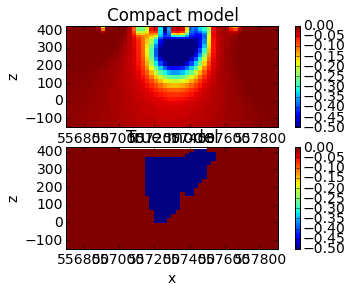

In [25]:
# Inject active cells back into the global mesh and view the recoverd model
m_IRLS = actvMap*mrec
m_IRLS[airc] = np.nan
plt.figure(figsize=[8,10])

def slide(s,normal):
    ax1 = plt.subplot(2,1,1)
    dat = mesh.plotSlice(m_IRLS, ax = ax1, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])
    plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('Compact model')
    
    ax2 = plt.subplot(2,1,2)
    dat = mesh.plotSlice(m_true, ax = ax2, normal=normal, ind=s, clim=np.r_[model.min(), model.max()])
    plt.colorbar(dat[0])
    plt.gca().set_aspect('equal')
    plt.title('True model')
    
interact(slide, s=(0,60), normal=['X','Y','Z'])

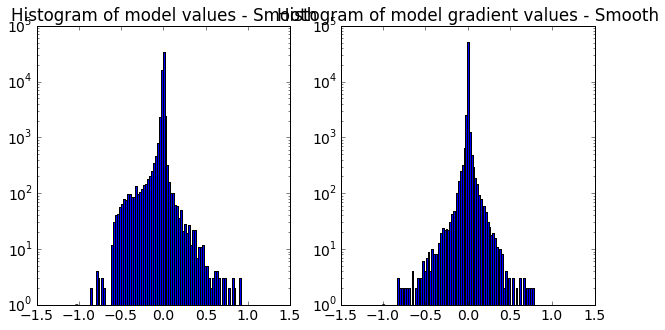

In [26]:
# Lets look at the distribution of model parameters and model gradients

plt.figure(figsize=[10,5])
ax = plt.subplot(121)
plt.hist(mrec,100)
plt.yscale('log', nonposy='clip')
plt.title('Histogram of model values - Smooth')
ax = plt.subplot(122)
plt.hist(reg.regmesh.cellDiffxStencil*mrec,100)
plt.yscale('log', nonposy='clip')
plt.title('Histogram of model gradient values - Smooth')

In [27]:
import pickle
Results = {"mesh":mesh, "model_true":dens, "model_pred":m_IRLS, "Obs":d, "XYZ": xyz}
outputs = open("Gravresults", 'wb')
pickle.dump(Results, outputs)
outputs.close()